In [1]:
import os
import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt

import torch
import torchvision

from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchvision import datasets, models
import torchvision.transforms as transforms
from PIL import Image
import cv2

import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim

import sklearn
from torchsummary import summary

from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device in Use:",device)

Device in Use: cuda


In [11]:
from sklearn.datasets import fetch_california_housing
california = fetch_california_housing()
print(california.data.shape, california.target.shape)
print(california.feature_names[0:8])

(20640, 8) (20640,)
['MedInc', 'HouseAge', 'AveRooms', 'AveBedrms', 'Population', 'AveOccup', 'Latitude', 'Longitude']


In [12]:
torch.manual_seed(42)

In [13]:
california = fetch_california_housing()
X, y = california.data, california.target
print(X.shape, y.shape)

columns = california.feature_names + ['MedHouseVal']
df = pd.DataFrame(data=np.c_[X, y], columns=columns)
e
print(df.head())

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Before Standardization:")
print(X_train[:3])
print(y_train[:3])

(20640, 8) (20640,)
   MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0  8.3252      41.0  6.984127   1.023810       322.0  2.555556     37.88   
1  8.3014      21.0  6.238137   0.971880      2401.0  2.109842     37.86   
2  7.2574      52.0  8.288136   1.073446       496.0  2.802260     37.85   
3  5.6431      52.0  5.817352   1.073059       558.0  2.547945     37.85   
4  3.8462      52.0  6.281853   1.081081       565.0  2.181467     37.85   

   Longitude  MedHouseVal  
0    -122.23        4.526  
1    -122.22        3.585  
2    -122.24        3.521  
3    -122.25        3.413  
4    -122.25        3.422  
Before Standardization:
[[ 3.25960000e+00  3.30000000e+01  5.01765650e+00  1.00642055e+00
   2.30000000e+03  3.69181380e+00  3.27100000e+01 -1.17030000e+02]
 [ 3.81250000e+00  4.90000000e+01  4.47354497e+00  1.04100529e+00
   1.31400000e+03  1.73809524e+00  3.37700000e+01 -1.18160000e+02]
 [ 4.15630000e+00  4.00000000e+00  5.64583333e+00  9.85119048e-01

In [14]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("\nAfter Standardization:")
print(X_train_scaled[:3])
X_train_scaled_df = pd.DataFrame(data=X_train_scaled, columns=california.feature_names)
X_test_scaled_df = pd.DataFrame(data=X_test_scaled, columns=california.feature_names)

print(X_train_scaled_df.head())


After Standardization:
[[-0.326196    0.34849025 -0.17491646 -0.20836543  0.76827628  0.05137609
  -1.3728112   1.27258656]
 [-0.03584338  1.61811813 -0.40283542 -0.12853018 -0.09890135 -0.11736222
  -0.87669601  0.70916212]
 [ 0.14470145 -1.95271028  0.08821601 -0.25753771 -0.44981806 -0.03227969
  -0.46014647 -0.44760309]]
     MedInc  HouseAge  AveRooms  AveBedrms  Population  AveOccup  Latitude  \
0 -0.326196  0.348490 -0.174916  -0.208365    0.768276  0.051376 -1.372811   
1 -0.035843  1.618118 -0.402835  -0.128530   -0.098901 -0.117362 -0.876696   
2  0.144701 -1.952710  0.088216  -0.257538   -0.449818 -0.032280 -0.460146   
3 -1.017864  0.586545 -0.600015  -0.145156   -0.007434  0.077507 -1.382172   
4 -0.171488  1.142008  0.349007   0.086624   -0.485877 -0.068832  0.532084   

   Longitude  
0   1.272587  
1   0.709162  
2  -0.447603  
3   1.232698  
4  -0.108551  


In [15]:
# Convert to torch tensors
X_train_torch = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_torch = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_torch = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_torch = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

print("\nAfter Converting to Torch Tensor:")
print(X_train_torch.shape, y_train_torch.shape)
print(X_train_torch[:3])
print(y_train_torch[:3])


After Converting to Torch Tensor:
torch.Size([16512, 8]) torch.Size([16512, 1])
tensor([[-0.3262,  0.3485, -0.1749, -0.2084,  0.7683,  0.0514, -1.3728,  1.2726],
        [-0.0358,  1.6181, -0.4028, -0.1285, -0.0989, -0.1174, -0.8767,  0.7092],
        [ 0.1447, -1.9527,  0.0882, -0.2575, -0.4498, -0.0323, -0.4601, -0.4476]])
tensor([[1.0300],
        [3.8210],
        [1.7260]])


In [66]:
train_dataset = TensorDataset(X_train_torch, y_train_torch)
test_dataset = TensorDataset(X_test_torch, y_test_torch)

batch_size = 32

trainloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
testloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [19]:
class RegressionNet(nn.Module):
    def __init__(self):
        super(RegressionNet, self).__init__()
        self.fc1 = nn.Linear(X.shape[1], 128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 1)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [20]:
net = RegressionNet()
net = net.to(device)
print(net)

RegressionNet(
  (fc1): Linear(in_features=8, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
)


In [23]:
class AdamOptimizer:
    def __init__(self, parameters, lr=0.001, betas=(0.9, 0.999), epsilon=1e-8):
        self.parameters = list(parameters)
        self.lr = lr
        self.betas = betas
        self.epsilon = epsilon
        self.t = 0
        self.m = [torch.zeros_like(p) for p in self.parameters]  # Initialize first moment vector
        self.v = [torch.zeros_like(p) for p in self.parameters]  # Initialize second moment vector

    def zero_grad(self):
        for p in self.parameters:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        self.t += 1
        with torch.no_grad():
            for i, p in enumerate(self.parameters):
                if p.grad is not None:
                    self.m[i] = self.betas[0] * self.m[i] + (1 - self.betas[0]) * p.grad
                    self.v[i] = self.betas[1] * self.v[i] + (1 - self.betas[1]) * (p.grad ** 2)
                    m_hat = self.m[i] / (1 - self.betas[0] ** self.t)
                    v_hat = self.v[i] / (1 - self.betas[1] ** self.t)
                    # Update parameters
                    p.sub_((self.lr * m_hat) / (torch.sqrt(v_hat) + self.epsilon))

In [24]:
import torch

class NAGOptimizer:
    def __init__(self, parameters, lr=0.01, momentum=0.9):
        self.parameters = list(parameters)
        self.lr = lr
        self.momentum = momentum
        self.velocity = [torch.zeros_like(p) for p in self.parameters]

    def zero_grad(self):
        """Resets the gradient of all optimized torch.Tensor s."""
        for p in self.parameters:
            if p.grad is not None:
                p.grad.zero_()

    def step(self):
        """Performs a single optimization step (parameter update)."""
        with torch.no_grad():
            for i, p in enumerate(self.parameters):
                if p.grad is not None:
                    # Apply momentum
                    self.velocity[i] = self.velocity[i] * self.momentum + p.grad

                    lookahead_velocity = self.velocity[i] * self.momentum + p.grad
                    update = lookahead_velocity * self.lr

                    p.sub_(update)

In [25]:
def train_model(model, train_loader, test_loader, epochs, optimizer):
    loss_fn = nn.MSELoss()
    train_losses, val_losses = [], []

    for epoch in range(epochs):
        # Training phase
        model.train()
        total_loss, total_samples = 0, 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)  # Reshape targets if necessary
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

        train_losses.append(total_loss / total_samples)

        # Validation phase
        model.eval()
        total_val_loss, total_val_samples = 0, 0
        with torch.no_grad():
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)  # Reshape targets if necessary
                outputs = model(inputs)
                loss = loss_fn(outputs, targets)

                total_val_loss += loss.item() * inputs.size(0)
                total_val_samples += inputs.size(0)

        val_losses.append(total_val_loss / total_val_samples)

        print(f'Epoch {epoch+1}/{epochs}, Training Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')

    return train_losses, val_losses

In [31]:
# Train using Adam
net_adam = RegressionNet()
net_adam = net_adam.to(device)
optimizer_adam = AdamOptimizer(net_adam.parameters(), lr=0.0001)
adam_metrics = train_model(net_adam, trainloader, testloader, epochs=100, optimizer=optimizer_adam)

Epoch 1/100, Training Loss: 3.0734, Validation Loss: 1.2237
Epoch 2/100, Training Loss: 0.9892, Validation Loss: 0.7882
Epoch 3/100, Training Loss: 0.7040, Validation Loss: 0.6062
Epoch 4/100, Training Loss: 0.5607, Validation Loss: 0.5229
Epoch 5/100, Training Loss: 0.4909, Validation Loss: 0.4925
Epoch 6/100, Training Loss: 0.4584, Validation Loss: 0.4630
Epoch 7/100, Training Loss: 0.4371, Validation Loss: 0.4421
Epoch 8/100, Training Loss: 0.4222, Validation Loss: 0.4302
Epoch 9/100, Training Loss: 0.4094, Validation Loss: 0.4189
Epoch 10/100, Training Loss: 0.3982, Validation Loss: 0.4078
Epoch 11/100, Training Loss: 0.3884, Validation Loss: 0.4051
Epoch 12/100, Training Loss: 0.3815, Validation Loss: 0.3870
Epoch 13/100, Training Loss: 0.3751, Validation Loss: 0.3817
Epoch 14/100, Training Loss: 0.3688, Validation Loss: 0.3787
Epoch 15/100, Training Loss: 0.3640, Validation Loss: 0.3707
Epoch 16/100, Training Loss: 0.3591, Validation Loss: 0.3702
Epoch 17/100, Training Loss: 0.35

In [32]:
# Train using NAG
net_NAG = RegressionNet()
net_NAG = net_NAG.to(device)
optimizer_NAG = NAGOptimizer(net_NAG.parameters(), lr=0.0001)
NAG_metrics = train_model(net_NAG, trainloader, testloader, epochs=100, optimizer=optimizer_NAG)

Epoch 1/100, Training Loss: 2.2653, Validation Loss: 0.9028
Epoch 2/100, Training Loss: 0.7357, Validation Loss: 0.6554
Epoch 3/100, Training Loss: 0.6138, Validation Loss: 0.6095
Epoch 4/100, Training Loss: 0.5749, Validation Loss: 0.5773
Epoch 5/100, Training Loss: 0.5449, Validation Loss: 0.5504
Epoch 6/100, Training Loss: 0.5209, Validation Loss: 0.5288
Epoch 7/100, Training Loss: 0.5014, Validation Loss: 0.5118
Epoch 8/100, Training Loss: 0.4858, Validation Loss: 0.4975
Epoch 9/100, Training Loss: 0.4735, Validation Loss: 0.4868
Epoch 10/100, Training Loss: 0.4634, Validation Loss: 0.4790
Epoch 11/100, Training Loss: 0.4549, Validation Loss: 0.4725
Epoch 12/100, Training Loss: 0.4480, Validation Loss: 0.4628
Epoch 13/100, Training Loss: 0.4414, Validation Loss: 0.4572
Epoch 14/100, Training Loss: 0.4353, Validation Loss: 0.4502
Epoch 15/100, Training Loss: 0.4298, Validation Loss: 0.4468
Epoch 16/100, Training Loss: 0.4251, Validation Loss: 0.4399
Epoch 17/100, Training Loss: 0.42

In [33]:
def plot_losses(train_losses, val_losses, label):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label=f'{label} - Train Loss')
    plt.plot(epochs, val_losses, label=f'{label} - Val Loss')

    plt.title('Loss per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

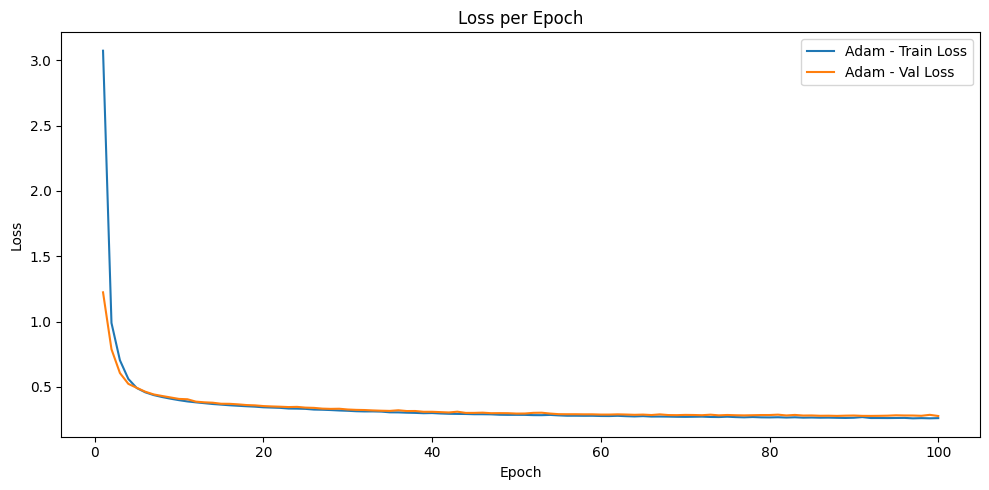

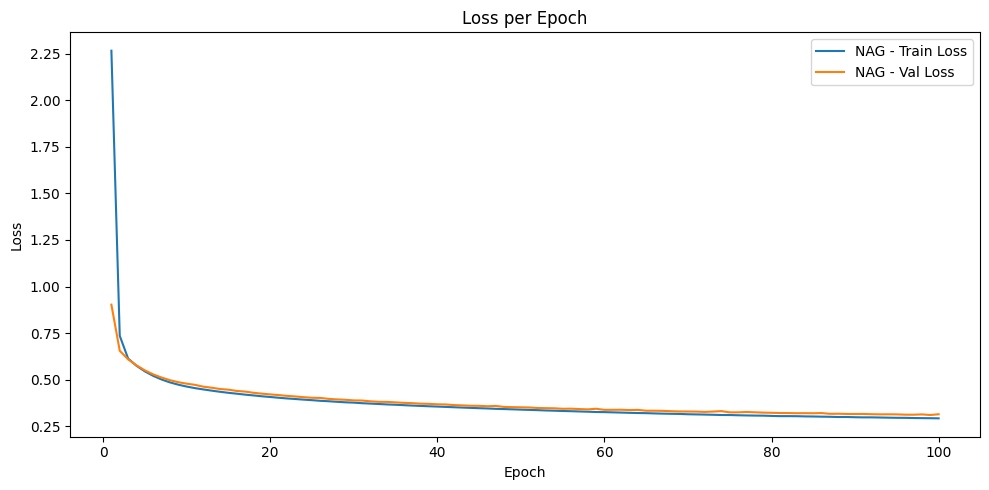

In [34]:
adam_train_losses, adam_val_losses = adam_metrics
NAG_train_losses, NAG_val_losses = NAG_metrics

plot_losses(adam_train_losses, adam_val_losses, 'Adam')
plot_losses(NAG_train_losses, NAG_val_losses, 'NAG')

In [51]:
# Train using Adam
net_adam_1 = RegressionNet()
net_adam_1 = net_adam_1.to(device)
opt = torch.optim.Adam(net_adam_1.parameters(), lr=0.0001)
adam_metrics_1 = train_model(net_adam_1, trainloader, testloader, epochs=100, optimizer=opt)

Epoch 1/100, Training Loss: 2.0479, Validation Loss: 0.9467
Epoch 2/100, Training Loss: 0.7396, Validation Loss: 0.6111
Epoch 3/100, Training Loss: 0.5443, Validation Loss: 0.5166
Epoch 4/100, Training Loss: 0.4770, Validation Loss: 0.4763
Epoch 5/100, Training Loss: 0.4450, Validation Loss: 0.4540
Epoch 6/100, Training Loss: 0.4247, Validation Loss: 0.4281
Epoch 7/100, Training Loss: 0.4102, Validation Loss: 0.4148
Epoch 8/100, Training Loss: 0.3987, Validation Loss: 0.4022
Epoch 9/100, Training Loss: 0.3889, Validation Loss: 0.3930
Epoch 10/100, Training Loss: 0.3800, Validation Loss: 0.3866
Epoch 11/100, Training Loss: 0.3745, Validation Loss: 0.3816
Epoch 12/100, Training Loss: 0.3685, Validation Loss: 0.3755
Epoch 13/100, Training Loss: 0.3630, Validation Loss: 0.3708
Epoch 14/100, Training Loss: 0.3591, Validation Loss: 0.3677
Epoch 15/100, Training Loss: 0.3550, Validation Loss: 0.3627
Epoch 16/100, Training Loss: 0.3506, Validation Loss: 0.3592
Epoch 17/100, Training Loss: 0.34

In [52]:
# Train using NAG
net_nag_1 = RegressionNet()
net_nag_1 = net_nag_1.to(device)
opt = torch.optim.SGD(net_nag_1.parameters(), lr=0.0001, momentum=0.9, nesterov=True)
nag_metrics_1 = train_model(net_nag_1, trainloader, testloader, epochs=100, optimizer=opt)

Epoch 1/100, Training Loss: 2.1657, Validation Loss: 0.9897
Epoch 2/100, Training Loss: 0.7732, Validation Loss: 0.6812
Epoch 3/100, Training Loss: 0.6419, Validation Loss: 0.6347
Epoch 4/100, Training Loss: 0.6060, Validation Loss: 0.6043
Epoch 5/100, Training Loss: 0.5774, Validation Loss: 0.5774
Epoch 6/100, Training Loss: 0.5512, Validation Loss: 0.5524
Epoch 7/100, Training Loss: 0.5274, Validation Loss: 0.5305
Epoch 8/100, Training Loss: 0.5062, Validation Loss: 0.5112
Epoch 9/100, Training Loss: 0.4874, Validation Loss: 0.4971
Epoch 10/100, Training Loss: 0.4718, Validation Loss: 0.4834
Epoch 11/100, Training Loss: 0.4585, Validation Loss: 0.4751
Epoch 12/100, Training Loss: 0.4476, Validation Loss: 0.4642
Epoch 13/100, Training Loss: 0.4383, Validation Loss: 0.4539
Epoch 14/100, Training Loss: 0.4309, Validation Loss: 0.4455
Epoch 15/100, Training Loss: 0.4243, Validation Loss: 0.4390
Epoch 16/100, Training Loss: 0.4185, Validation Loss: 0.4325
Epoch 17/100, Training Loss: 0.41

In [53]:
# Train using Adagrad
net_adagrad_1 = RegressionNet()
net_adagrad_1 = net_adagrad_1.to(device)
opt = torch.optim.Adagrad(net_adagrad_1.parameters(), lr=0.0001)
adagrad_metrics_1 = train_model(net_adagrad_1, trainloader, testloader, epochs=100, optimizer=opt)

Epoch 1/100, Training Loss: 4.9549, Validation Loss: 4.6067
Epoch 2/100, Training Loss: 4.4967, Validation Loss: 4.2251
Epoch 3/100, Training Loss: 4.1413, Validation Loss: 3.8999
Epoch 4/100, Training Loss: 3.8389, Validation Loss: 3.6248
Epoch 5/100, Training Loss: 3.5730, Validation Loss: 3.3775
Epoch 6/100, Training Loss: 3.3341, Validation Loss: 3.1557
Epoch 7/100, Training Loss: 3.1227, Validation Loss: 2.9611
Epoch 8/100, Training Loss: 2.9332, Validation Loss: 2.7836
Epoch 9/100, Training Loss: 2.7628, Validation Loss: 2.6288
Epoch 10/100, Training Loss: 2.6143, Validation Loss: 2.4929
Epoch 11/100, Training Loss: 2.4828, Validation Loss: 2.3718
Epoch 12/100, Training Loss: 2.3659, Validation Loss: 2.2644
Epoch 13/100, Training Loss: 2.2618, Validation Loss: 2.1682
Epoch 14/100, Training Loss: 2.1685, Validation Loss: 2.0824
Epoch 15/100, Training Loss: 2.0855, Validation Loss: 2.0062
Epoch 16/100, Training Loss: 2.0112, Validation Loss: 1.9374
Epoch 17/100, Training Loss: 1.94

In [54]:
# Train using Adamax
net_adamax_1 = RegressionNet()
net_adamax_1 = net_adamax_1.to(device)
opt = torch.optim.Adamax(net_adamax_1.parameters(), lr=0.0001)
adamax_metrics_1 = train_model(net_adamax_1, trainloader, testloader, epochs=100, optimizer=opt)

Epoch 1/100, Training Loss: 3.5935, Validation Loss: 2.0316
Epoch 2/100, Training Loss: 1.6431, Validation Loss: 1.4584
Epoch 3/100, Training Loss: 1.2594, Validation Loss: 1.2054
Epoch 4/100, Training Loss: 1.0733, Validation Loss: 1.0622
Epoch 5/100, Training Loss: 0.9624, Validation Loss: 0.9643
Epoch 6/100, Training Loss: 0.8888, Validation Loss: 0.8896
Epoch 7/100, Training Loss: 0.8319, Validation Loss: 0.8309
Epoch 8/100, Training Loss: 0.7806, Validation Loss: 0.7736
Epoch 9/100, Training Loss: 0.7375, Validation Loss: 0.7283
Epoch 10/100, Training Loss: 0.6990, Validation Loss: 0.6875
Epoch 11/100, Training Loss: 0.6643, Validation Loss: 0.6509
Epoch 12/100, Training Loss: 0.6347, Validation Loss: 0.6205
Epoch 13/100, Training Loss: 0.6077, Validation Loss: 0.5937
Epoch 14/100, Training Loss: 0.5848, Validation Loss: 0.5709
Epoch 15/100, Training Loss: 0.5642, Validation Loss: 0.5518
Epoch 16/100, Training Loss: 0.5465, Validation Loss: 0.5363
Epoch 17/100, Training Loss: 0.53

In [55]:
# Train using Adadelta
net_adadelta_1 = RegressionNet()
net_adadelta_1 = net_adadelta_1.to(device)
opt = torch.optim.Adadelta(net_adadelta_1.parameters(), lr=0.0001)
adadelta_metrics_1 = train_model(net_adadelta_1, trainloader, testloader, epochs=100, optimizer=opt)

Epoch 1/100, Training Loss: 5.2207, Validation Loss: 5.1138
Epoch 2/100, Training Loss: 5.1915, Validation Loss: 5.0827
Epoch 3/100, Training Loss: 5.1587, Validation Loss: 5.0494
Epoch 4/100, Training Loss: 5.1241, Validation Loss: 5.0147
Epoch 5/100, Training Loss: 5.0879, Validation Loss: 4.9780
Epoch 6/100, Training Loss: 5.0500, Validation Loss: 4.9402
Epoch 7/100, Training Loss: 5.0112, Validation Loss: 4.9011
Epoch 8/100, Training Loss: 4.9706, Validation Loss: 4.8606
Epoch 9/100, Training Loss: 4.9294, Validation Loss: 4.8199
Epoch 10/100, Training Loss: 4.8877, Validation Loss: 4.7781
Epoch 11/100, Training Loss: 4.8446, Validation Loss: 4.7350
Epoch 12/100, Training Loss: 4.8002, Validation Loss: 4.6908
Epoch 13/100, Training Loss: 4.7554, Validation Loss: 4.6464
Epoch 14/100, Training Loss: 4.7097, Validation Loss: 4.6008
Epoch 15/100, Training Loss: 4.6632, Validation Loss: 4.5547
Epoch 16/100, Training Loss: 4.6165, Validation Loss: 4.5083
Epoch 17/100, Training Loss: 4.56

In [56]:
# Train using Vanilla GD
net_vanilla_gd_1 = RegressionNet()
net_vanilla_gd_1 = net_vanilla_gd_1.to(device)
opt = torch.optim.SGD(net_vanilla_gd_1.parameters(), lr=0.0001, momentum=0)
vanilla_gd_metrics_1 = train_model(net_vanilla_gd_1, trainloader, testloader, epochs=100, optimizer=opt)

Epoch 1/100, Training Loss: 5.4063, Validation Loss: 4.7529
Epoch 2/100, Training Loss: 4.3301, Validation Loss: 3.7656
Epoch 3/100, Training Loss: 3.3787, Validation Loss: 2.8661
Epoch 4/100, Training Loss: 2.5220, Validation Loss: 2.0980
Epoch 5/100, Training Loss: 1.8523, Validation Loss: 1.5804
Epoch 6/100, Training Loss: 1.4599, Validation Loss: 1.3312
Epoch 7/100, Training Loss: 1.2787, Validation Loss: 1.2134
Epoch 8/100, Training Loss: 1.1808, Validation Loss: 1.1330
Epoch 9/100, Training Loss: 1.1055, Validation Loss: 1.0624
Epoch 10/100, Training Loss: 1.0378, Validation Loss: 0.9971
Epoch 11/100, Training Loss: 0.9748, Validation Loss: 0.9371
Epoch 12/100, Training Loss: 0.9169, Validation Loss: 0.8822
Epoch 13/100, Training Loss: 0.8639, Validation Loss: 0.8332
Epoch 14/100, Training Loss: 0.8164, Validation Loss: 0.7905
Epoch 15/100, Training Loss: 0.7749, Validation Loss: 0.7537
Epoch 16/100, Training Loss: 0.7394, Validation Loss: 0.7226
Epoch 17/100, Training Loss: 0.70

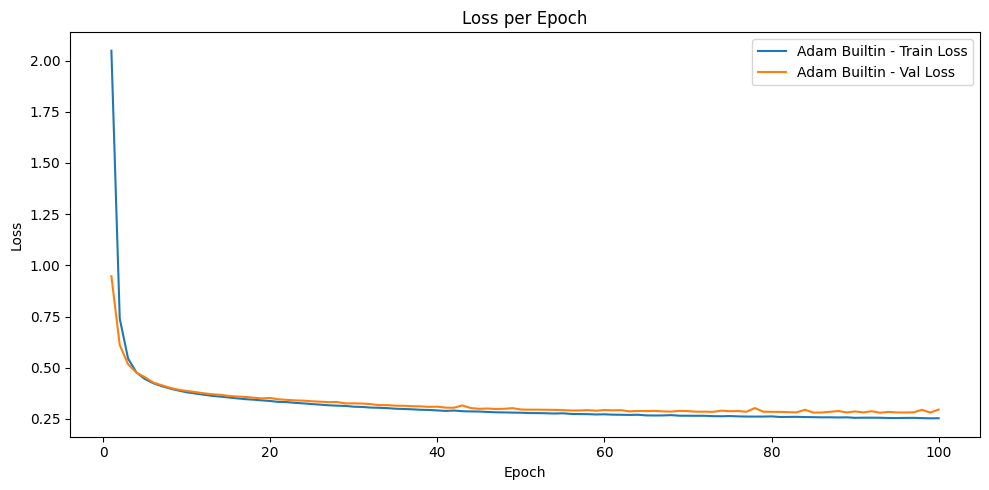

In [57]:
adam_train_losses_1, adam_val_losses_1 = adam_metrics_1

plot_losses(adam_train_losses_1, adam_val_losses_1, 'Adam Builtin')

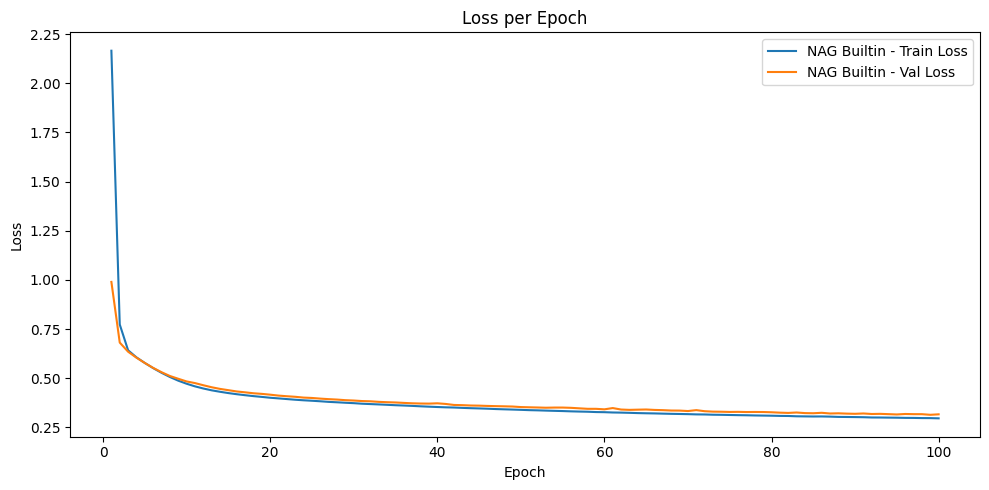

In [58]:
nag_train_losses_1, nag_val_losses_1 = nag_metrics_1

plot_losses(nag_train_losses_1, nag_val_losses_1, 'NAG Builtin')

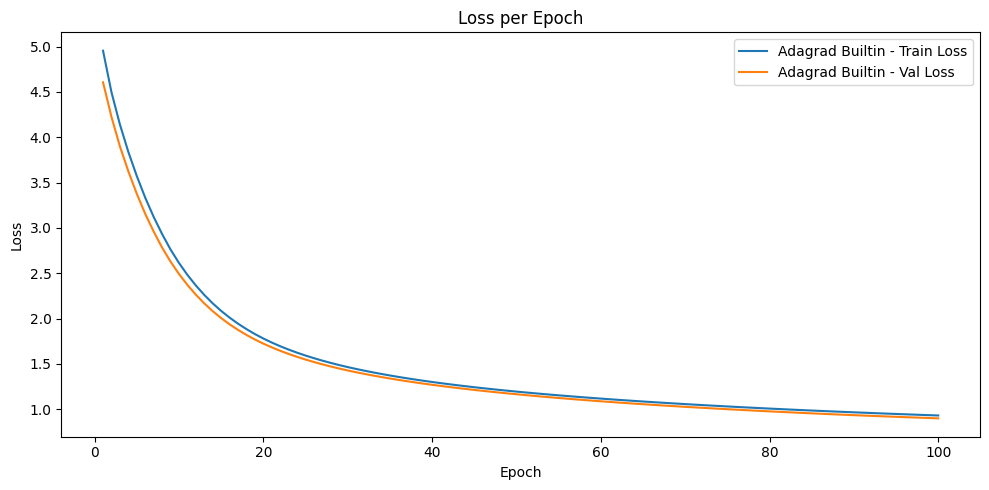

In [59]:
adagrad_train_losses_1, adagrad_val_losses_1 = adagrad_metrics_1

plot_losses(adagrad_train_losses_1, adagrad_val_losses_1, 'Adagrad Builtin')

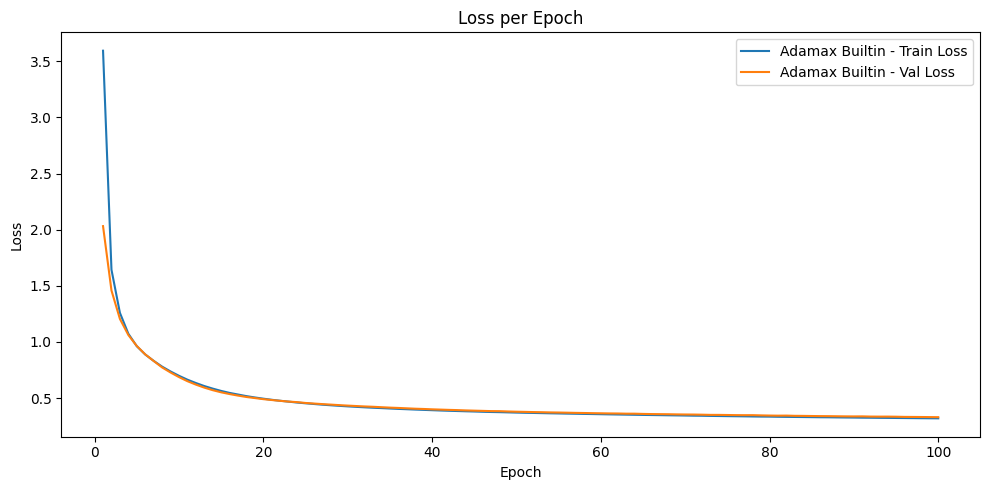

In [60]:
adamax_train_losses_1, adamax_val_losses_1 = adamax_metrics_1

plot_losses(adamax_train_losses_1, adamax_val_losses_1, 'Adamax Builtin')

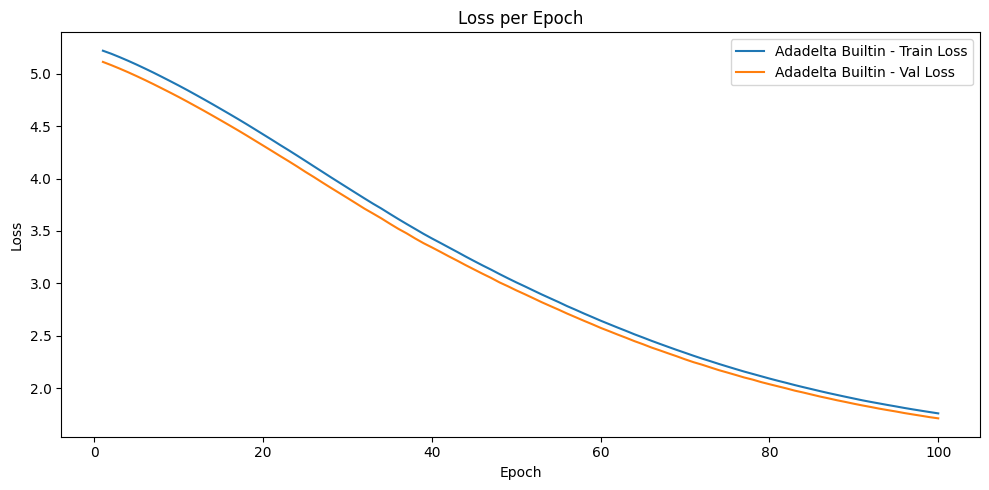

In [61]:
adadelta_train_losses_1, adadelta_val_losses_1 = adadelta_metrics_1

plot_losses(adadelta_train_losses_1, adadelta_val_losses_1, 'Adadelta Builtin')

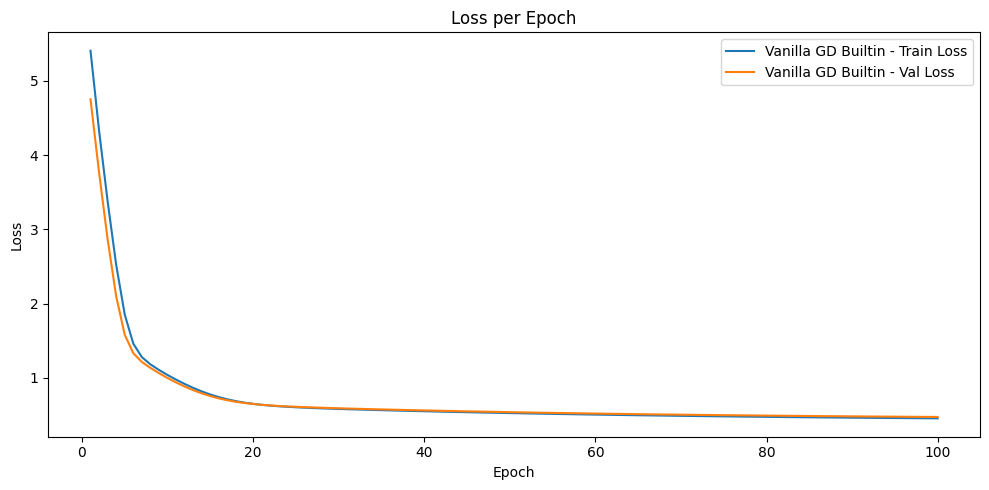

In [62]:
vanilla_gd_train_losses_1, vanilla_gd_val_losses_1 = vanilla_gd_metrics_1

plot_losses(vanilla_gd_train_losses_1, vanilla_gd_val_losses_1, 'Vanilla GD Builtin')

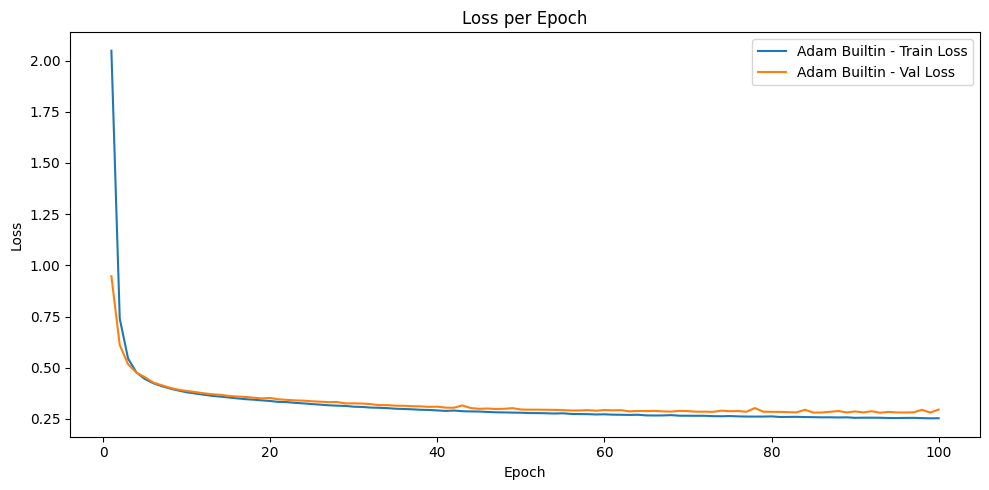

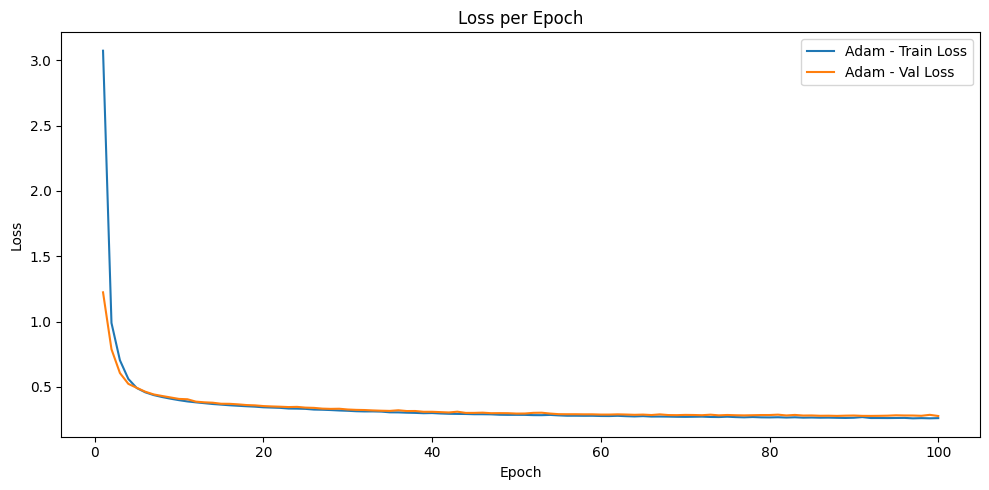

In [63]:
adam_train_losses_1, adam_val_losses_1 = adam_metrics_1
adam_train_losses, adam_val_losses = adam_metrics

plot_losses(adam_train_losses_1, adam_val_losses_1, 'Adam Builtin')
plot_losses(adam_train_losses, adam_val_losses, 'Adam')

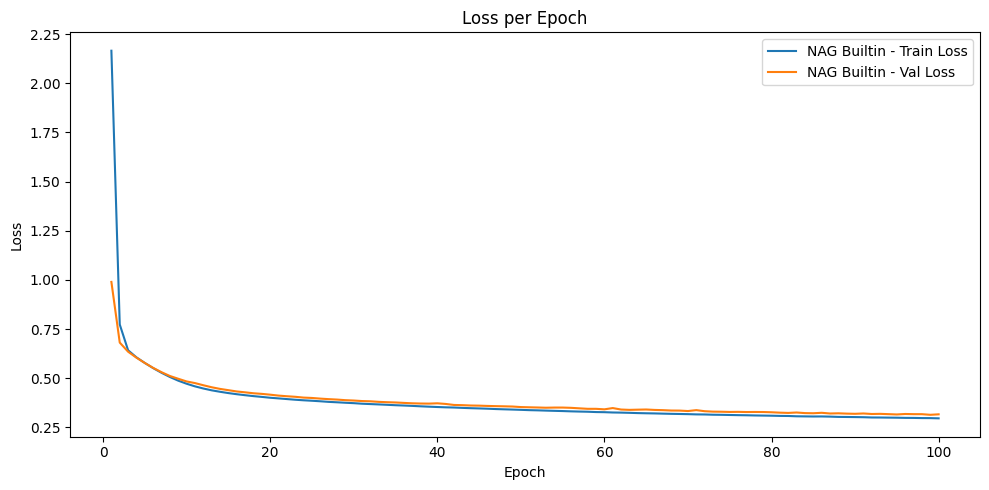

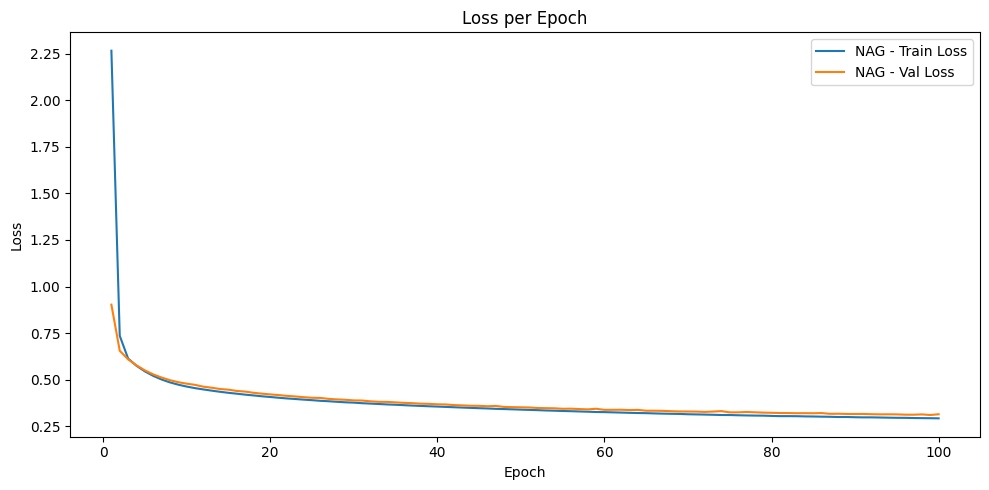

In [64]:
nag_train_losses_1, nag_val_losses_1 = nag_metrics_1
nag_train_losses, nag_val_losses = NAG_metrics

plot_losses(nag_train_losses_1, nag_val_losses_1, 'NAG Builtin')
plot_losses(nag_train_losses, nag_val_losses, 'NAG')